In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [8]:
img = cv2.imread("a.png")

In [9]:
img.shape

(660, 660, 3)

In [2]:
from torchvision import transforms

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

img_size = 400

mean, std = np.array(mean, dtype=float), np.array(std, dtype=float)

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

inv_norm = transforms.Compose([
    transforms.Normalize(np.zeros(3), 1/std),
    transforms.Normalize(-mean, np.ones(3))
])

to_pil = transforms.Compose([
    inv_norm,
    transforms.Lambda(lambda img: torch.clamp(img, 0, 1)),
    transforms.ToPILImage()
])

In [5]:
from PIL import Image

pimg = Image.open("a.jpg")
x = ToTensor()(pimg)

ToPILImage()(x)
x.shape

torch.Size([3, 660, 660])

In [4]:
from torchvision.transforms import ToTensor,ToPILImage
from PIL import Image
import torch
import torch.nn.functional as F

In [6]:
######################### device ##########################
device = torch.device("cpu")
######################### lgs ##########################
def get_gx(tensor):  # (B,C,H,W)
    B, C, W, H = tensor.shape
    sobelx = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], device=device).float()
    sobely = sobelx.T
    G_x = F.conv2d(tensor.view(-1, 1, W, H), sobelx.view((1, 1, 3, 3)), padding=1).view(B, C, W, H)
    G_y = F.conv2d(tensor.view(-1, 1, W, H), sobely.view((1, 1, 3, 3)), padding=1).view(B, C, W, H)

    G = torch.sqrt(torch.pow(G_x, 2) + torch.pow(G_y, 2)).float()

    gx = (G-G.min())/(G.max()-G.min())

    return gx

def get_gradient(tensor, block_size=15, overlap=5, threshold=0.1):
    # tensor shape : (B,C,H,W)
    stride = block_size - overlap
    padding = []
    for v in tensor.shape[-2:]:
        left = v % stride
        if left <= overlap:
            need = overlap
        else:
            need = block_size
        pad = need - left
        padding.append(int(pad / 2))
        padding.append(pad - padding[-1])

    tensor = F.pad(tensor, tuple(padding))

    B, C, W, H = tensor.shape

    patches = tensor.unfold(2, block_size, stride).unfold(3, block_size, stride)
    # torch.Size([1, 3, 30, 30, 15, 15])
    # (patches.sum([1, -2, -1]) torch.Size([1, 30, 30])
    # print(patches.shape)
    # torch.prod(torch.tensor(patches.shape)[[1, -2, -1]])) | · | denotes the cardinality of each patch
    mask = ((patches.sum([1, -2, -1]) / torch.prod(torch.tensor(patches.shape)[[1, -2, -1]])) >= threshold).float().unsqueeze(1).unsqueeze(-1).unsqueeze(-1)

    def fold(x):
        x = x * mask
        x = x.contiguous().view(B, C, -1, block_size * block_size).permute(0, 1, 3, 2)
        x = x.contiguous().view(B, C * block_size * block_size, -1)
        return F.fold(x, output_size=(H, W), kernel_size=block_size, stride=stride)

    ox = torch.ones_like(patches)
    r = fold(patches) / fold(ox)
    r = F.pad(r, tuple(-i for i in padding))

    r[r != r] = 0

    return r

def apply_gradient(img, grad, smooth_factor=2.3):
    t = 1 - grad * smooth_factor
    # λ ∗ g(x) is clipped between 0 and 1
    # https://pytorch.org/docs/stable/generated/torch.clip.html
    clipped = torch.clip(t, 0, 1)
    # https://blog.csdn.net/Real_Brilliant/article/details/85756477
    return torch.mul(img, clipped)

# tensor ： image data
def lgs(tensor, threshold=0.1, smooth_factor=2.3, block_size=15, overlap=5):
    return apply_gradient(tensor, get_gradient(get_gx(tensor), block_size=block_size, overlap=overlap, threshold=threshold), smooth_factor=smooth_factor)


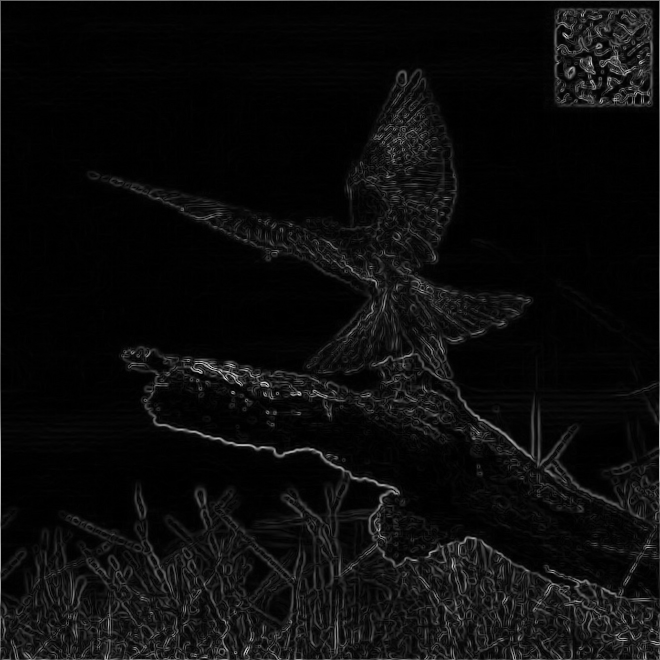

In [9]:
img = Image.open("a.jpg")
img = ToTensor()(img)
C,H,W = img.shape
bImgs = img.reshape(1,C,H,W)
gx = get_gx(bImgs)
ToPILImage()(gx.squeeze().mean(0).unsqueeze(0))

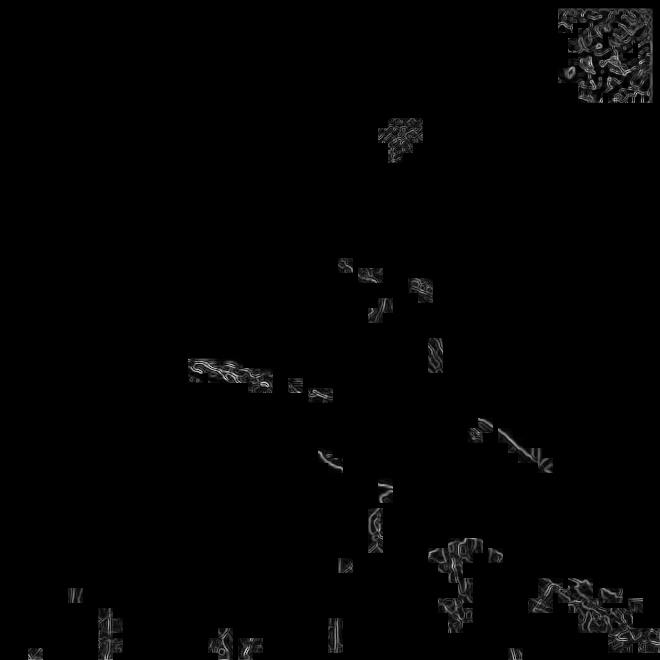

In [25]:
thresholded_gx = get_gradient(gx, block_size=15, overlap=5, threshold=0.15)
ToPILImage()(thresholded_gx.squeeze().mean(0).unsqueeze(0))

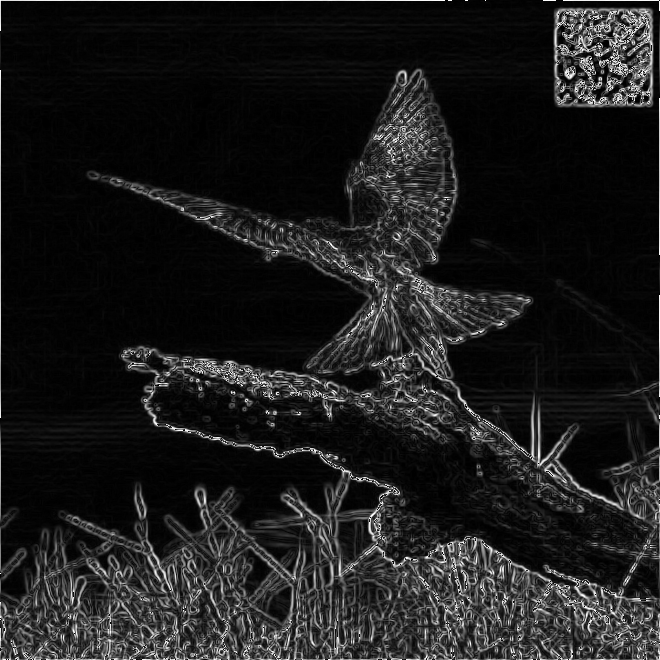

In [27]:
ToPILImage()(get_gx(x.unsqueeze(0)).squeeze().sum(0).unsqueeze(0))

In [32]:
def imshow(img, *args, **kwargs):
    new_img = img.copy()
    new_img[:,:,[0,2]] = new_img[:,:,[2,0]]
    
    plt.imshow(new_img, *args, **kwargs)

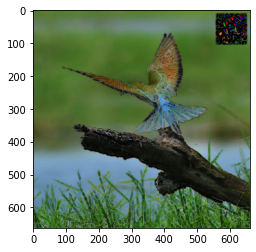

In [33]:
imshow(img)

In [22]:
import torch
import torch.nn.functional as F

def get_gx(tensor):
    B, C, W, H = tensor.shape
    sobelx = torch.tensor([[1,0,-1], [2,0,-2], [1,0,-1]], device="cpu").float()
    sobely = sobelx.T

    G_x = F.conv2d(tensor.view(-1,1, W, H), sobelx.view((1,1,3,3)),padding=1).view(B, C, W, H)
    G_y = F.conv2d(tensor.view(-1,1, W, H), sobely.view((1,1,3,3)),padding=1).view(B, C, W, H)

    G = torch.sqrt(torch.pow(G_x, 2)+torch.pow(G_y, 2)).float()

    gx = (G-G.min())/(G.max()-G.min())
    return gx

In [170]:
def get_gx(img, ksize=3):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
    dx = np.sqrt(sobelx**2 + sobely**2)
    gx = (dx-dx.min())/(dx.max()-dx.min())
    return gx
    

In [5]:
ksize = 7
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


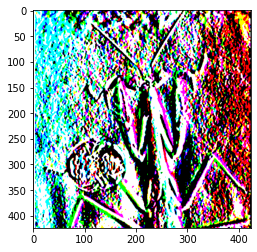

In [6]:
plt.imshow(sobelx, cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


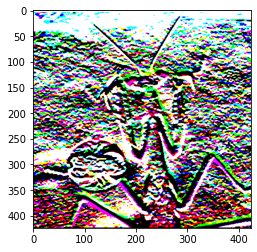

In [7]:
plt.imshow(sobely, cmap="gray")

In [172]:
get_gx(img).shape

(663, 660, 3)

In [6]:
img = cv2.imread("../bird.png")
t = np.linalg.norm(get_gx(img,7), axis=2)

In [69]:
np.linalg.norm(t, axis=2).shape

(663, 660)

In [13]:
x = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float()
B, C, W, H = x.shape

In [156]:
sobelx = torch.tensor([[1,0,-1], [2,0,-2], [1,0,-1]]).view((1,1,3,3)).float()
sobelx.dtype

torch.float32

In [14]:
import torch
import torch.nn.functional as F

sobelx = torch.tensor([[1,0,-1], [2,0,-2], [1,0,-1]]).float()
sobely = sobelx.T

G_x = F.conv2d(x.view(-1,1, W, H), sobelx.view((1,1,3,3)),padding=1).view(B, C, W, H)
G_y = F.conv2d(x.view(-1,1, W, H), sobely.view((1,1,3,3)),padding=1).view(B, C, W, H)

G = torch.sqrt(torch.pow(G_x, 2)+torch.pow(G_y, 2)).float()

gx = (G-G.min())/(G.max()-G.min())


In [19]:
gx.sum(dim=1).shape

torch.Size([1, 663, 660])

In [217]:
gx.shape

torch.Size([1, 3, 663, 660])

In [200]:
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)

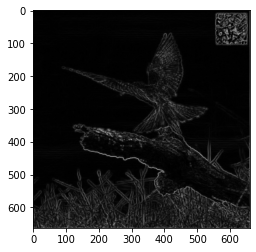

In [20]:
plt.imshow(gx.sum(dim=1).squeeze(), cmap="gray")

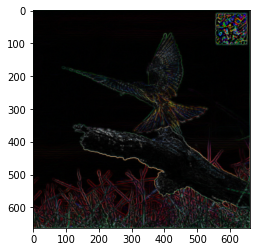

In [15]:
plt.imshow(gx.squeeze().permute(1,2,0), cmap="gray")

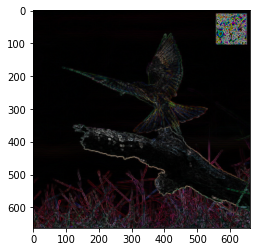

In [221]:
gx = get_gx(img)
plt.imshow(gx, cmap="gray")

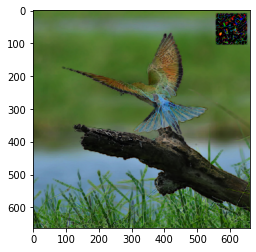

In [9]:
l = 2
tx = np.multiply(img, np.clip(1-l*gx, 0, 1))
imshow(tx.astype(int))


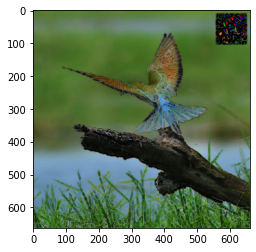

In [6]:
imshow(img)

In [11]:
cv2.imwrite('a.png', tx)

True

In [22]:
tx.astype(int).dtype

dtype('int32')

In [73]:
def split(matrix, block_size, overlap):
    result = [[]]
    xn_matrices = np.ceil(matrix.shape[0]/(block_size[0]-overlap[0]))
    yn_matrices = np.ceil(matrix.shape[1]/(block_size[1]-overlap[1]))
    xi=0
    yi=0

    for xi in range(int(xn_matrices)):
        xi = xi * (block_size[0]-overlap[0])
        for yi in range(int(yn_matrices)):
            yi = yi * (block_size[1]-overlap[1])
    #         print(yi)
            new_xi = xi + block_size[0]
            if new_xi > matrix.shape[0]:
                new_yi = yi + block_size[1]
                if new_yi > matrix.shape[1]:
                    mini_matrix = matrix[-block_size[0]:, -block_size[1]:, ...]
                    
                else:
                    mini_matrix = matrix[-block_size[0]:, yi: new_yi, ...]
            else:
                new_yi = yi + block_size[1]
                if new_yi > matrix.shape[1]:
                    mini_matrix = matrix[xi: new_xi, -block_size[1]:, ...]
                else:
                    mini_matrix = matrix[xi:new_xi, yi:new_yi, ...]
            result[-1].append(mini_matrix)
        result.append([])
    result.pop()
    return result

In [41]:
r=split(gx_merged, block_size, overlap)


In [50]:
from math import ceil

ceil(423 / 10)

43

In [108]:
threshold = 0.2
matrix = gx
block_size = (15,15)
overlap = (5,5)

result = np.zeros(matrix.shape)
xn_matrices = np.ceil(matrix.shape[0]/(block_size[0]-overlap[0]))
yn_matrices = np.ceil(matrix.shape[1]/(block_size[1]-overlap[1]))
xi=0
yi=0

for xi in range(int(xn_matrices)):
    xi = xi * (block_size[0]-overlap[0])
    for yi in range(int(yn_matrices)):
        yi = yi * (block_size[1]-overlap[1])
        slice_params = []
        new_xi = xi + block_size[0]
        if new_xi > matrix.shape[0]:
            slice_params.append(slice(-block_size[0], None))
        else:
            slice_params.append(slice(xi, new_xi))
            
        new_yi = yi + block_size[1]
        if new_yi > matrix.shape[1]:
            slice_params.append(slice(-block_size[1], None))
        else:
            slice_params.append(slice(yi, new_yi))
        
        slice_params = tuple(slice_params)
        mini_matrix = matrix[slice_params]
        if mini_matrix.sum() / np.prod(mini_matrix.shape) > threshold:
            result[slice_params] = mini_matrix


In [12]:
def get_gradient(matrix, block_size=(15,15), overlap=(5,5), threshold=0):
    result = np.zeros(matrix.shape)
    xn_matrices = np.ceil(matrix.shape[0]/(block_size[0]-overlap[0]))
    yn_matrices = np.ceil(matrix.shape[1]/(block_size[1]-overlap[1]))
    xi=0
    yi=0

    for xi in range(int(xn_matrices)):
        xi = xi * (block_size[0]-overlap[0])
        for yi in range(int(yn_matrices)):
            yi = yi * (block_size[1]-overlap[1])
            slice_params = []
            new_xi = xi + block_size[0]
            if new_xi > matrix.shape[0]:
                slice_params.append(slice(-block_size[0], None))
            else:
                slice_params.append(slice(xi, new_xi))

            new_yi = yi + block_size[1]
            if new_yi > matrix.shape[1]:
                slice_params.append(slice(-block_size[1], None))
            else:
                slice_params.append(slice(yi, new_yi))

            slice_params = tuple(slice_params)
            mini_matrix = matrix[slice_params]
            if mini_matrix.sum() / np.prod(mini_matrix.shape) > threshold:
                result[slice_params] = mini_matrix
    return result

def apply_gradient(img, grad, smooth_factor=2.3):
    return np.multiply(img, np.clip(1 - smooth_factor * grad, 0, 1))

In [8]:
import torch

def get_gradient_2(matrix, block_size=15, overlap=5, threshold=0):
    
#     print(patches.shape)
    return patches

In [26]:
F.pad(input=torch.tensor(gx), pad=(0, 0, 2, 3, 1, 1), mode='constant', value=0).shape

torch.Size([665, 665, 3])

torch.Size([1, 3, 66, 66, 15, 15])
torch.Size([1, 675, 4356])


RuntimeError: "col2im_out_cpu" not implemented for 'Byte'

In [270]:
ksize = 15
stride=10

x = torch.tensor(img).unsqueeze(0).permute(0,3,1,2)
print(x.shape)


patches = x.unfold(2, ksize, stride).unfold(3, ksize, stride)
opatches = torch.ones(x.shape).unfold(2, ksize, stride).unfold(3, ksize, stride)
opatches.min()

torch.Size([1, 3, 663, 660])


tensor(1.)

In [271]:
t=(patches.sum([1,-2,-1]) / torch.prod(torch.tensor(patches.shape)[[1,-2,-1]]) > 0.2).float()


In [237]:
(patches * t.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)).max()

tensor(1., dtype=torch.float64)

In [277]:
import torch.nn.functional as F

patches = (patches * t.unsqueeze(1).unsqueeze(-1).unsqueeze(-1))
# opatches = (opatches * t.unsqueeze(1).unsqueeze(-1).unsqueeze(-1))

patches = patches.contiguous().view(1, 3, -1, 15*15)
patches = patches.permute(0, 1, 3, 2)
patches = patches.contiguous().view(1, 3*15*15, -1)
output = F.fold(patches, output_size=(x.shape[-2], x.shape[-1]), kernel_size=15, stride=10)

opatches = opatches.contiguous().view(1, 3, -1, 15*15)
opatches = opatches.permute(0, 1, 3, 2)
opatches = opatches.contiguous().view(1, 3*15*15, -1)
ooutput = F.fold(opatches, output_size=(x.shape[-2], x.shape[-1]), kernel_size=15, stride=10)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 14975081550000 bytes. Buy new RAM!

In [274]:
dx = ooutput
t = (dx-dx.min())/(dx.max()-dx.min())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


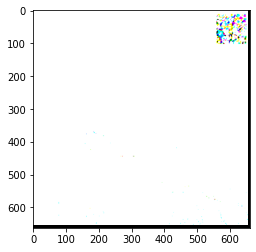

In [275]:
plt.imshow((output/ooutput)[0].permute(1,2,0), cmap="gray")

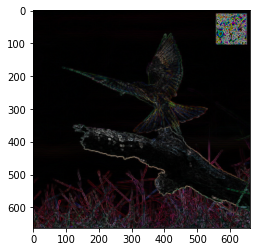

In [268]:
plt.imshow(get_gradient(gx), cmap='gray')

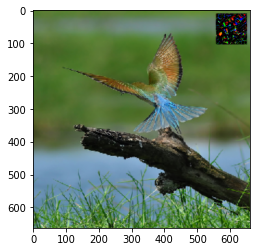

In [267]:
imshow(apply_gradient(img, get_gradient(gx, threshold=0.2)).astype(int))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 65, 65, 15, 15])
torch.float32
torch.Size([1, 3, 65, 65, 15, 15])
torch.float32


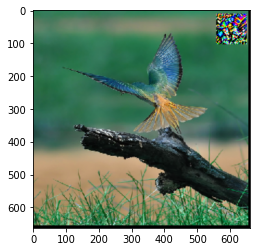

In [276]:
plt.imshow((fold_unfold(x) / fold_unfold(torch.ones(x.shape)))[0].permute(1,2,0).int())


In [51]:
patches = get_gradient_2(gx)
patches.shape

torch.Size([1, 66, 66, 3, 15, 15])

In [113]:
get_gradient(gx).max()

1.0

In [93]:
np.prod(mini_matrix.shape)

225

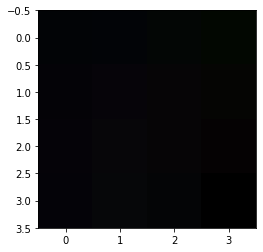

In [16]:
plt.imshow(result[-1][-1])

In [13]:
block_size = (15, 15)
overlap = (5, 5)
threshold = 0.1

